# Testing the non-Markovian Path Analysis Package
 

In [1]:
import numpy as np
from math import pi,sin,exp
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.interpolate
import matplotlib.cm as cm
import networkx as nx

from NMpathAnalysis.nmtools.interval import Interval
from NMpathAnalysis.nmtools.functions import *
from NMpathAnalysis.src.ensemble import *

In [2]:
N = 6 # global variable: number of partitions per dimension in the 2D toy model

In [3]:
def energy(x,y):
    if (x > 6*pi) or (x < 0) or (y > 6*pi) or (y < 0):
        return 10**10
    else:
        ener = 1.5*(1 - sin(x) * sin(y)) + 0.0009*(((x - (9 * sin(y/3) + y))**2) * (y - (9*sin(x/3) + x))**2)
        return ener

In [4]:
def plot_traj(list_of_trajs, discrete=[False], line_width=0.5, std = 0.3, color='k'):
    

    length = 6*pi
    #----------

    xlist = np.linspace(0,length)
    ylist = np.linspace(0,length)
    X,Y = np.meshgrid(xlist, ylist)

    Z = np.array([[energy(X[i,j],Y[i,j]) for i in range(len(X))] for j in range(len(X))])

    plt.figure(figsize=(8,6.5))

    #im = plt.imshow(Z,interpolation='bilinear',vmin = -5,vmax =5,cmap=cm.Spectral,alpha=0.5)
    #plt.colorbar(im)

    levels = list(np.arange(0, 10, 0.2))
    plt.contourf(X, Y, Z,levels,linestyles = 'solid',cmap=cm.jet, alpha =0.5)
        
    for i,element in enumerate(list_of_trajs):
        if type(line_width) == list:
            lw = line_width[i]
        else:
            lw = line_width
            
        if not discrete[i]:
            plt.plot(element[0],element[1], color=color, linewidth=lw)
        else:
            xi = np.array(element[0])
            x_values = [((length/N)*(int(index/N) + 0.5) + np.random.normal(0, std)) for index in xi]
            y_values = [((length/N)*(index%N + 0.5) + np.random.normal(0, std)) for index in xi]
            plt.plot(x_values, y_values, color=color, linewidth=lw)


    plt.axis([0, length, 0, length])
    plt.yticks([i*pi for i in range(7)],[' ','$\pi$','$2\pi$','$3\pi$','$4\pi$','$5\pi$','$6\pi$'],fontsize = 15)
    plt.xticks([i*pi for i in range(7)],['0','$\pi$','$2\pi$','$3\pi$','$4\pi$','$5\pi$','$6\pi$'],fontsize = 15)
    plt.xlabel('X', fontsize = 13)
    plt.ylabel('Y', fontsize = 13)

    plt.grid(linewidth = 1,linestyle='--',alpha=0.6)

    plt.colorbar()
    plt.show() 


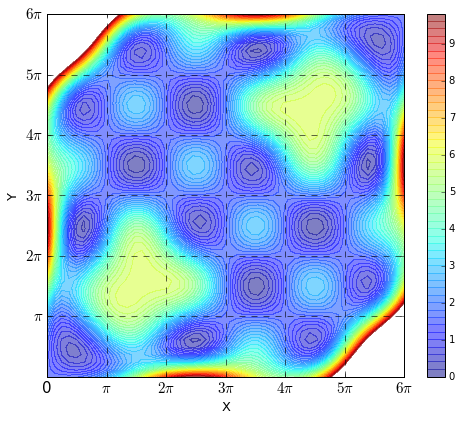

In [5]:
plot_traj([],[])

In [6]:
'''
MC simulation
'''
def mc_simulation2D(numsteps):
    x = 1; y = 1
    mc_traj = []
    
    for i in range(numsteps):
        dx = np.random.uniform(-pi,pi)
        dy = np.random.uniform(-pi,pi)
        if (np.random.random() < exp(-(energy(x+dx,y+dy)-energy(x,y))) ):
            x = x + dx; y = y + dy
        mc_traj += [[x,y]]
        

    return np.array(mc_traj)

In [7]:
'''
Simple mapping funcion 
'''
def mapping_function2D(vector2D):

    length = 6*pi
    #----------
    x = vector2D[0]
    y = vector2D[1]
    return N*int(x*N/length)+int(y*N/length)

## MC simulation

In [8]:
#Generating MC trajectories
mc_traj1_2d = mc_simulation2D(100000)
mc_traj2_2d = mc_simulation2D(10000)



## 1- Ensemble class (analysis of continuos trajectories)

Stores an esemble (list) of trajectories (np.arrays). The ensemble could have any number of trajectories including no trajectories at all.

### Creating an Ensemble
From a single trajectory:


In [9]:
my_ensemble = Ensemble(mc_traj1_2d)

From a list of trajectories:

In [10]:
# We have to set list_of_trajs = True
my_ensemble = Ensemble([mc_traj1_2d, mc_traj2_2d],list_of_trajs = True)

print(my_ensemble[1])

for traj in my_ensemble:
    print(traj[0])

[[  1.           1.        ]
 [  1.           1.        ]
 [  1.           1.        ]
 ..., 
 [  8.22594833  14.82077885]
 [  8.22594833  14.82077885]
 [  8.22594833  14.82077885]]
[ 1.  1.]
[ 1.  1.]


### Adding trajectories to the Ensemble
New trajectories can be added to the ensemble as long as there is consistency in the number of variables.

In [11]:
my_ensemble = Ensemble()
my_ensemble.add_trajectory(mc_traj1_2d)

print(my_ensemble)

Ensemble with 1 (2-dimensional) trajectories


In [12]:
n_states = N**2
C1 = my_ensemble._count_matrix(n_states, mapping_function2D)
print(C1)

[[ 5300.    91.     0. ...,     0.     0.     0.]
 [   91.   501.    72. ...,     0.     0.     0.]
 [    0.    62.  3715. ...,     0.     0.     0.]
 ..., 
 [    0.     0.     0. ...,  3806.    80.     0.]
 [    0.     0.     0. ...,    72.   715.   120.]
 [    0.     0.     0. ...,     0.   113.  6047.]]


In [13]:
K1 = my_ensemble._mle_transition_matrix(n_states, mapping_function2D)
print(K1)

[[ 0.9643377   0.0165575   0.         ...,  0.          0.          0.        ]
 [ 0.13037249  0.71776504  0.10315186 ...,  0.          0.          0.        ]
 [ 0.          0.01460886  0.87535344 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.87233555  0.01833601  0.        ]
 [ 0.          0.          0.         ...,  0.07507821  0.7455683
   0.12513034]
 [ 0.          0.          0.         ...,  0.          0.01799363
   0.96289809]]


### Defining states and computing MFPTs
The states are considered intervals in the is the class is Ensemble

In [14]:
stateA = [[0,pi],[0,pi]]
stateB = [[5*pi,6*pi],[5*pi,6*pi]]

my_ensemble.mfpts(stateA, stateB)

{'mfptAB': 1307.2,
 'mfptBA': 1544.1142857142856,
 'std_err_mfptAB': 199.47101799611931,
 'std_err_mfptBA': 209.07196601591744}

### Sum of ensembles (ensemble + ensemble)

In [15]:
seq1 = mc_simulation2D(20000)
seq2 = mc_simulation2D(20000)

my_e1 = Ensemble(seq1)
my_e2 = Ensemble(seq2)

ensemble1 = my_e1 + my_e2


In [16]:
ensemble1.mfpts(stateA,stateB)

{'mfptAB': 1508.0,
 'mfptBA': 1887.0,
 'std_err_mfptAB': 316.73676855640804,
 'std_err_mfptBA': 535.81957784313931}

Another simple example

In [17]:
e1 = Ensemble([1,2,3,4])
e2 = Ensemble([2,3,4,5])
e3 = Ensemble([2,1,1,4])

my_ensembles = [e1, e2, e3]

ensemble_tot = Ensemble([])

for ens in my_ensembles:
    ensemble_tot += ens

ensemble_tot.trajectories
ensemble_tot.mfpts([1,1],[4,4])

{'mfptAB': 2.5,
 'mfptBA': 'NaN',
 'std_err_mfptAB': 0.35355339059327373,
 'std_err_mfptBA': 'NaN'}


## 2- DiscreteEnsemble class

We can generate a discrete trajectory from the same mapping function and we should obtain exaclty the same result:

In [18]:
d_ens = DiscreteEnsemble.from_ensemble( mc_traj1_2d, mapping_function2D)

In [19]:
C2 = d_ens._count_matrix(n_states)
print(C2)

[[ 5300.    91.     0. ...,     0.     0.     0.]
 [   91.   501.    72. ...,     0.     0.     0.]
 [    0.    62.  3715. ...,     0.     0.     0.]
 ..., 
 [    0.     0.     0. ...,  3806.    80.     0.]
 [    0.     0.     0. ...,    72.   715.   120.]
 [    0.     0.     0. ...,     0.   113.  6047.]]


In [20]:
K2= d_ens._mle_transition_matrix(n_states)
print(K2)

[[ 0.9643377   0.0165575   0.         ...,  0.          0.          0.        ]
 [ 0.13037249  0.71776504  0.10315186 ...,  0.          0.          0.        ]
 [ 0.          0.01460886  0.87535344 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.87233555  0.01833601  0.        ]
 [ 0.          0.          0.         ...,  0.07507821  0.7455683
   0.12513034]
 [ 0.          0.          0.         ...,  0.          0.01799363
   0.96289809]]


### Defining states and computing MFPTs
The states are now considered sets, defining the states as follow we should obtain the same results

In [21]:
stateA = [0]
stateB = [N*N-1]

d_ens.mfpts(stateA, stateB)

{'mfptAB': 1307.2,
 'mfptBA': 1544.1142857142856,
 'std_err_mfptAB': 199.47101799611931,
 'std_err_mfptBA': 209.07196601591744}

### Generating trajectories from the transition matrix

In [22]:
d_ens2 = DiscreteEnsemble.from_transition_matrix(K2, sim_length = 100000)

In [23]:
d_ens2.mfpts(stateA,stateB)

{'mfptAB': 846.8148148148148,
 'mfptBA': 998.5471698113207,
 'std_err_mfptAB': 104.15820730778107,
 'std_err_mfptBA': 139.73863505657397}

## 3 - DiscretePathEnsemble

In [24]:
dpathEnsemble = DiscretePathEnsemble.from_transition_matrix(K2,stateA = stateA, stateB = stateB, n_paths = 1,ini_pops = [1])
print(dpathEnsemble)

DiscretePathEnsemble with 1 (1-dimensional) trajectories


In [25]:
FSs = dpathEnsemble.fundamental_sequences(K2)
size = len(FSs)

paths = dpathEnsemble.trajectories

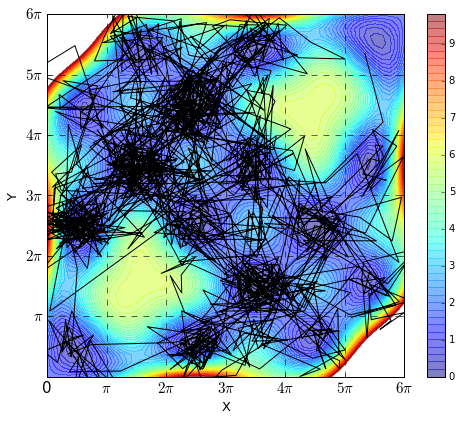

In [26]:
discrete = [True for i in range(size)]
lw = [1 for i in range(size)]
#print(line_width)

plot_traj([[paths[i],[]] for i in range(size)] ,discrete,line_width=lw,std=1)

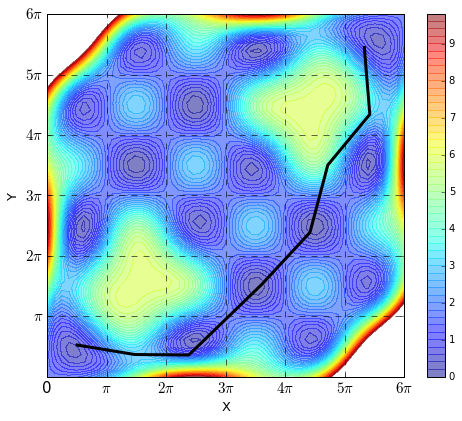

In [27]:
plot_traj([[FSs[i],[]] for i in range(size)] ,discrete, line_width=3)

In [28]:
reduced_FSs, weights = dpathEnsemble.weighted_fundamental_sequences(K2)
new_size = len(weights)
lw = [weights[i]*20 for i in range(new_size)] 

In [29]:
# plot_traj([[reduced_FSs[i],[]] for i in range(new_size)] ,discrete=[True for i in range(new_size)],\
#           line_width = lw,std = 0.001 ) 

In [30]:
### for i,w in enumerate(weights):
#     print(w,' ',reduced_FSs[i])

In [31]:
# G = nx.DiGraph()
# G.add_nodes_from(list(range(N*N)))
# max_path = 2
# count = 0
# for path in reduced_FSs:
#     for i in range(len(path)-1):
#         G.add_edge(path[i],path[i+1], weight = 0)
#     count+=1
#     if count >= max_path: break
# nx.draw_random(G,with_labels=True)

In [32]:
print(dpathEnsemble._mle_transition_matrix(N*N))

[[ 0.91304348  0.04347826  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.5        ...,  0.          0.          0.        ]
 [ 0.          0.00862069  0.88793103 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.8         0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
